# Cell 1: Import required libraries

In [2]:
# Cell 1: Import required libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import random
import joblib
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download required NLTK data
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

print("All libraries imported successfully!")

All libraries imported successfully!


# Cell 2: Data Preparation Class Definition

In [3]:
# Cell 2: Updated Data Preparation Class Definition
"""
Data Preparation for ML Chatbot
Handles dataset loading, preprocessing, and splitting
"""

class IntentDataPreprocessor:
    def __init__(self, data_path):
        self.data_path = data_path
        self.data = None
        self.df = None
        self.label_encoder = LabelEncoder()
        self.stemmer = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))
        
    def load_data(self):
        """Load intent data from JSON file - Kaggle compatible"""
        try:
            with open(self.data_path, 'r', encoding='utf-8') as f:
                self.data = json.load(f)
            print(f"✅ Successfully loaded data from: {self.data_path}")
        except FileNotFoundError:
            print(f"❌ File not found at {self.data_path}. Searching for JSON files...")
            
            json_files = []
            for dirname, _, filenames in os.walk('/kaggle'):
                for filename in filenames:
                    if filename.endswith('.json'):
                        json_files.append(os.path.join(dirname, filename))
            
            if json_files:
                print("📄 Found JSON files:")
                for file in json_files:
                    print(f"   - {file}")
                
                # Load the first JSON file found
                try:
                    with open(json_files[0], 'r', encoding='utf-8') as f:
                        self.data = json.load(f)
                    print(f"✅ Successfully loaded data from: {json_files[0]}")
                    self.data_path = json_files[0]
                except Exception as e:
                    print(f"❌ Error loading {json_files[0]}: {e}")
            else:
                print("❌ No JSON files found in Kaggle directories")
                return None
                
        return self.data
    
    def preprocess_text(self, text):
        """Clean and preprocess text data"""
        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Tokenize and remove stopwords
        tokens = text.split()
        tokens = [token for token in tokens if token not in self.stop_words]
        
        # Apply stemming
        tokens = [self.stemmer.stem(token) for token in tokens]
        
        return ' '.join(tokens)
    
    def create_training_data(self):
        """Create training data from intents"""
        if not self.data:
            self.load_data()
            
        patterns = []
        labels = []
        
        for intent in self.data['intents']:
            for pattern in intent['patterns']:
                # Preprocess each pattern
                processed_pattern = self.preprocess_text(pattern)
                patterns.append(processed_pattern)
                labels.append(intent['tag'])
        
        # Create DataFrame
        self.df = pd.DataFrame({
            'text': patterns,
            'label': labels
        })
        
        # Encode labels and store encoded version
        encoded_labels = self.label_encoder.fit_transform(labels)
        self.df['encoded_label'] = encoded_labels
        
        return patterns, encoded_labels
    
    def split_data(self, test_size=0.2, random_state=42):
        """Split data into training and test sets """
        if self.df is None:
            self.create_training_data()
            
        X = self.df['text']
        y = self.df['encoded_label']  # Use encoded labels instead of original labels
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        return X_train, X_test, y_train, y_test
    
    def get_label_mapping(self):
        """Get mapping between encoded labels and original tags"""
        return dict(zip(
            self.label_encoder.classes_, 
            range(len(self.label_encoder.classes_))
        ))
    
    def get_class_distribution(self):
        """Get distribution of classes in the dataset"""
        if self.df is not None:
            return self.df['label'].value_counts()
        return None

print("Data Preprocessor class defined successfully!")

Data Preprocessor class defined successfully!


# Cell 3: Example usage of Data Preprocessor

In [4]:
# Cell 3: data preprocessing
print("🔍 Checking available files in Kaggle...")
for dirname, _, filenames in os.walk('/kaggle'):
    for filename in filenames:
        if filename.endswith('.json'):
            print(f"📄 Found: {os.path.join(dirname, filename)}")

# Load and preprocess data
preprocessor = IntentDataPreprocessor('/kaggle/input/intents/intents.json')
data_loaded = preprocessor.load_data()

if data_loaded is None:
    print("📝 No JSON file found, using sample data...")
    sample_intents = {
        "intents": [
            {
                "tag": "greeting",
                "patterns": ["Hello", "Hi", "Hey", "Good morning", "Good afternoon"],
                "responses": ["Hello! How can I help you?", "Hi there!", "Greetings!"]
            },
            {
                "tag": "goodbye",
                "patterns": ["Bye", "Goodbye", "See you later", "Take care"],
                "responses": ["Goodbye!", "See you soon!", "Have a great day!"]
            }
        ]
    }
    preprocessor.data = sample_intents

# Test the preprocessor 
X, y = preprocessor.create_training_data()
X_train, X_test, y_train, y_test = preprocessor.split_data()

print(f"\n📊 Dataset Summary:")
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")
print(f"   Number of classes: {len(preprocessor.label_encoder.classes_)}")
print(f"   Classes: {list(preprocessor.label_encoder.classes_)}")
print("\n📈 Class distribution:")
print(preprocessor.get_class_distribution())
print(f"   y_train type: {type(y_train.iloc[0]) if hasattr(y_train, 'iloc') else type(y_train[0])}")
print(f"   y_test type: {type(y_test.iloc[0]) if hasattr(y_test, 'iloc') else type(y_test[0])}")

🔍 Checking available files in Kaggle...
📄 Found: /kaggle/input/intents/intents.json
✅ Successfully loaded data from: /kaggle/input/intents/intents.json

📊 Dataset Summary:
   Training samples: 10710
   Test samples: 2678
   Number of classes: 27
   Classes: ['about_ai', 'books', 'business', 'capabilities', 'complaints', 'compliments', 'education', 'feelings', 'food', 'games', 'goodbye', 'greeting', 'health', 'help', 'jokes', 'movies', 'music', 'name_query', 'science', 'sports', 'stories', 'technology', 'thanks', 'time', 'travel', 'user_name', 'weather']

📈 Class distribution:
label
about_ai        12517
thanks            211
goodbye           162
greeting          150
feelings           56
help               50
weather            18
compliments        16
jokes              14
time               14
sports             12
complaints         12
stories            12
technology         12
science            12
food               12
capabilities       11
music              10
books          

# Cell 4: Model Training Class Definition

In [5]:
# Cell 4: Model Training Class Definition
"""
Model Training for Intent Classification
Trains and evaluates multiple ML algorithms
"""

class IntentClassifierTrainer:
    def __init__(self):
        self.models = {}
        self.best_model = None
        self.vectorizer = None
        self.results = {}
        
    def create_pipelines(self):
        """Create ML pipelines with different algorithms"""
        self.models = {
            'naive_bayes': Pipeline([
                ('tfidf', TfidfVectorizer(
                    max_features=5000,
                    ngram_range=(1, 2),
                    stop_words='english',
                    min_df=2,
                    max_df=0.8
                )),
                ('classifier', MultinomialNB(alpha=0.1))
            ]),
            
            'svm': Pipeline([
                ('tfidf', TfidfVectorizer(
                    max_features=5000,
                    ngram_range=(1, 2),
                    stop_words='english',
                    min_df=2,
                    max_df=0.8
                )),
                ('classifier', SVC(
                    kernel='linear',
                    C=1.0,
                    probability=True,
                    random_state=42
                ))
            ]),
            
            'logistic_regression': Pipeline([
                ('tfidf', TfidfVectorizer(
                    max_features=5000,
                    ngram_range=(1, 2),
                    stop_words='english',
                    min_df=2,
                    max_df=0.8
                )),
                ('classifier', LogisticRegression(
                    C=1.0,
                    max_iter=1000,
                    random_state=42,
                    multi_class='ovr'
                ))
            ]),
            
            'random_forest': Pipeline([
                ('tfidf', TfidfVectorizer(
                    max_features=5000,
                    ngram_range=(1, 2),
                    stop_words='english',
                    min_df=2,
                    max_df=0.8
                )),
                ('classifier', RandomForestClassifier(
                    n_estimators=100,
                    random_state=42,
                    max_depth=10
                ))
            ])
        }
    
    def train_models(self, X_train, y_train):
        """Train all models and measure training time"""
        self.create_pipelines()
        self.results = {}
        
        for name, model in self.models.items():
            print(f"🔄 Training {name}...")
            start_time = time.time()
            
            model.fit(X_train, y_train)
            
            training_time = time.time() - start_time
            self.results[name] = {
                'model': model,
                'training_time': training_time
            }
            
            print(f"   ✅ {name} trained in {training_time:.2f} seconds")
    
    def evaluate_models(self, X_test, y_test):
        """Evaluate all models on test data"""
        print("\n📊 Model Evaluation Results:")
        for name in self.models.keys():
            model = self.results[name]['model']
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            
            self.results[name]['accuracy'] = accuracy
            self.results[name]['predictions'] = y_pred
            
            print(f"   {name.upper():<20} Accuracy: {accuracy:.4f}")
    
    def get_best_model(self):
        """Select the best performing model"""
        best_accuracy = 0
        best_model_name = None
        
        for name, result in self.results.items():
            if result['accuracy'] > best_accuracy:
                best_accuracy = result['accuracy']
                best_model_name = name
        
        if best_model_name:
            self.best_model = self.results[best_model_name]['model']
            print(f"\n🏆 Best model: {best_model_name} with accuracy: {best_accuracy:.4f}")
            return self.best_model
        
        return None
    
    def detailed_classification_report(self, X_test, y_test, label_encoder):
        """Generate detailed classification report for best model"""
        if self.best_model:
            y_pred = self.best_model.predict(X_test)
            
            # Convert encoded labels back to original names
            y_test_labels = label_encoder.inverse_transform(y_test)
            y_pred_labels = label_encoder.inverse_transform(y_pred)
            
            print("\n📈 Detailed Classification Report:")
            print(classification_report(y_test_labels, y_pred_labels))
            
            return classification_report(y_test_labels, y_pred_labels, output_dict=True)
        return None
    
    def plot_confusion_matrix(self, X_test, y_test, label_encoder, figsize=(10, 8)):
        """Plot confusion matrix for best model"""
        if self.best_model:
            y_pred = self.best_model.predict(X_test)
            y_test_labels = label_encoder.inverse_transform(y_test)
            y_pred_labels = label_encoder.inverse_transform(y_pred)
            
            cm = confusion_matrix(y_test_labels, y_pred_labels, 
                                labels=label_encoder.classes_)
            
            plt.figure(figsize=figsize)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=label_encoder.classes_,
                       yticklabels=label_encoder.classes_)
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
    
    def save_model(self, filepath):
        """Save the best model to disk"""
        if self.best_model:
            joblib.dump(self.best_model, filepath)
            print(f"💾 Model saved to {filepath}")
        else:
            print("❌ No model to save. Train a model first.")
    
    def save_vectorizer(self, filepath):
        """Save the TF-IDF vectorizer to disk"""
        if self.best_model:
            vectorizer = self.best_model.named_steps['tfidf']
            joblib.dump(vectorizer, filepath)
            print(f"💾 Vectorizer saved to {filepath}")

print("Model Trainer class defined successfully!")

Model Trainer class defined successfully!


# Cell 5: Example usage of Model Trainer

🚀 Starting Model Training with FIXED data...
🔄 Training naive_bayes...
   ✅ naive_bayes trained in 0.16 seconds
🔄 Training svm...
   ✅ svm trained in 4.39 seconds
🔄 Training logistic_regression...
   ✅ logistic_regression trained in 0.79 seconds
🔄 Training random_forest...
   ✅ random_forest trained in 0.48 seconds

📊 Model Evaluation Results:
   NAIVE_BAYES          Accuracy: 0.9727
   SVM                  Accuracy: 0.9731
   LOGISTIC_REGRESSION  Accuracy: 0.9660
   RANDOM_FOREST        Accuracy: 0.9354

🏆 Best model: svm with accuracy: 0.9731

📋 Generating detailed reports...

📈 Detailed Classification Report:
              precision    recall  f1-score   support

    about_ai       0.98      1.00      0.99      2504
       books       1.00      0.50      0.67         2
    business       1.00      0.50      0.67         2
capabilities       0.00      0.00      0.00         2
  complaints       0.00      0.00      0.00         2
 compliments       0.00      0.00      0.00         3
 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

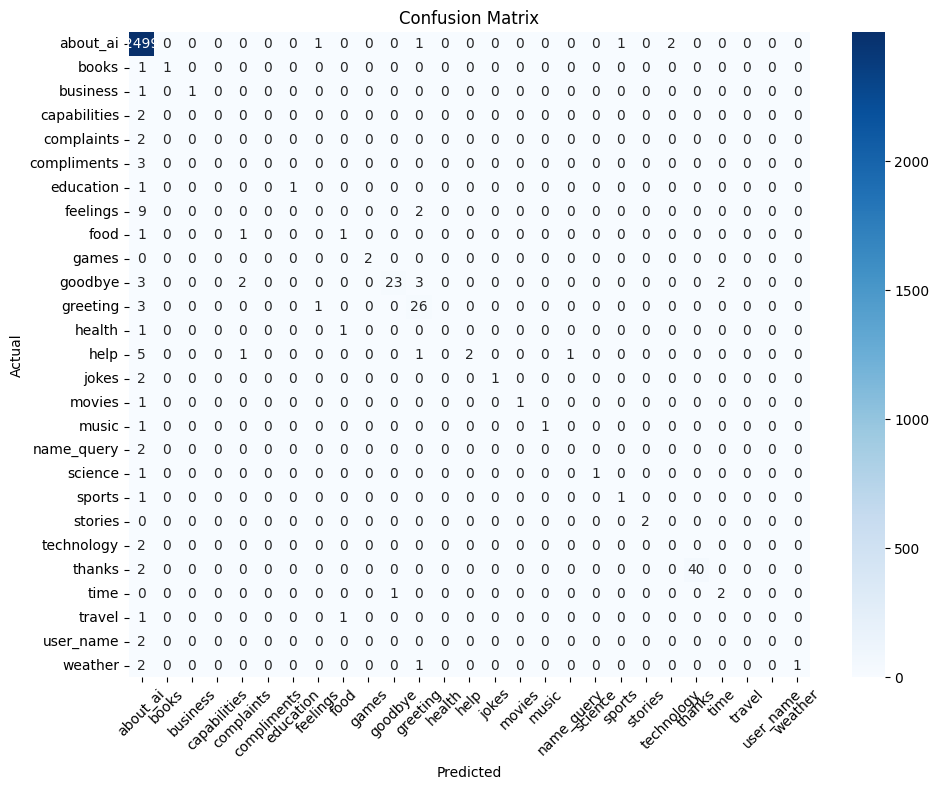


💾 Saving models...
💾 Model saved to best_intent_classifier.joblib
💾 Vectorizer saved to tfidf_vectorizer.joblib
✅ Model training completed!


In [6]:
# Cell 5: Run the model training with the fixed data
print("🚀 Starting Model Training with FIXED data...")

# Train models
trainer = IntentClassifierTrainer()
trainer.train_models(X_train, y_train)
trainer.evaluate_models(X_test, y_test)
trainer.get_best_model()

# Generate detailed reports - This should work now!
print("\n📋 Generating detailed reports...")
trainer.detailed_classification_report(X_test, y_test, preprocessor.label_encoder)

print("\n📊 Plotting confusion matrix...")
trainer.plot_confusion_matrix(X_test, y_test, preprocessor.label_encoder)

# Save the best model
print("\n💾 Saving models...")
trainer.save_model('best_intent_classifier.joblib')
trainer.save_vectorizer('tfidf_vectorizer.joblib')

print("✅ Model training completed!")

# Cell 6: Chatbot Application Class Definition

In [7]:
# Cell 6: Chatbot Application Class Definition
"""
ML-Powered Chatbot
Main chatbot application using trained ML model
"""

class MLChatbot:
    def __init__(self, intents_file, model_file=None, vectorizer_file=None):
        self.intents_file = intents_file
        self.model_file = model_file
        self.vectorizer_file = vectorizer_file
        
        # Load intents data
        self.preprocessor = IntentDataPreprocessor(intents_file)
        self.intents_data = self.preprocessor.load_data()
        
        # If no data loaded, create sample data
        if self.intents_data is None:
            print("📝 No JSON file found, creating sample data...")
            self.intents_data = {
                "intents": [
                    {
                        "tag": "greeting",
                        "patterns": ["Hello", "Hi", "Hey", "Good morning", "Good afternoon"],
                        "responses": ["Hello! How can I help you?", "Hi there!", "Greetings!"]
                    },
                    {
                        "tag": "goodbye",
                        "patterns": ["Bye", "Goodbye", "See you later", "Take care"],
                        "responses": ["Goodbye!", "See you soon!", "Have a great day!"]
                    },
                    {
                        "tag": "thanks",
                        "patterns": ["Thank you", "Thanks", "Thanks a lot", "I appreciate it"],
                        "responses": ["You're welcome!", "Happy to help!", "Anytime!"]
                    }
                ]
            }
            self.preprocessor.data = self.intents_data
        
        self.intents = self.intents_data['intents']
        
        # Initialize model and vectorizer
        self.model = None
        self.vectorizer = None
        self.label_encoder = None
        
        # Context tracking
        self.context = {}
        self.conversation_history = []
        
        # Load or train model
        if model_file and vectorizer_file and os.path.exists(model_file) and os.path.exists(vectorizer_file):
            self.load_model(model_file, vectorizer_file)
        else:
            self.train_model()
    
    def train_model(self):
        """Train the intent classification model"""
        print("🔄 Training ML model...")
        
        # Prepare data - this will also fit the label encoder
        X, y = self.preprocessor.create_training_data()
        X_train, X_test, y_train, y_test = self.preprocessor.split_data()
        self.label_encoder = self.preprocessor.label_encoder
        
        # Train models
        trainer = IntentClassifierTrainer()
        trainer.train_models(X_train, y_train)
        trainer.evaluate_models(X_test, y_test)
        trainer.get_best_model()
        
        self.model = trainer.best_model
        self.vectorizer = self.model.named_steps['tfidf']
        
        print("✅ Model training completed!")
        print(f"✅ Label encoder fitted with {len(self.label_encoder.classes_)} classes")
    
    def load_model(self, model_file, vectorizer_file):
        """Load pre-trained model and vectorizer"""
        try:
            print(f"📥 Loading model from {model_file}...")
            self.model = joblib.load(model_file)
            self.vectorizer = joblib.load(vectorizer_file)
            
           
            print("🔄 Fitting label encoder with intents data...")
            if self.preprocessor.df is None:
                self.preprocessor.create_training_data()
            
            self.label_encoder = self.preprocessor.label_encoder
            
            print("✅ Model loaded successfully!")
            print(f"✅ Label encoder fitted with {len(self.label_encoder.classes_)} classes")
            print(f"   Classes: {list(self.label_encoder.classes_)}")
            
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            print("🔄 Training new model instead...")
            self.train_model()
    
    def preprocess_input(self, text):
        """Preprocess user input using the same method as training"""
        return self.preprocessor.preprocess_text(text)
    
    def predict_intent(self, user_input):
        """Predict intent from user input"""
        if not self.model:
            raise ValueError("Model not loaded or trained")
        
        if self.label_encoder is None:
            raise ValueError("Label encoder not initialized. Please train or load model first.")
        
        # Preprocess input
        processed_input = self.preprocess_input(user_input)
        
        # Predict intent
        prediction = self.model.predict([processed_input])[0]
        confidence = np.max(self.model.predict_proba([processed_input]))
        
        # Convert back to intent tag
        intent_tag = self.label_encoder.inverse_transform([prediction])[0]
        
        return intent_tag, confidence, processed_input
    
    def get_response(self, intent_tag, confidence=1.0, confidence_threshold=0.6):
        """Get response for predicted intent"""
        # Note: confidence is now a parameter with default value
        if confidence < confidence_threshold:
            return self.get_fallback_response()
        
        for intent in self.intents:
            if intent['tag'] == intent_tag:
                response = random.choice(intent['responses'])
                return response
        
        return self.get_fallback_response()
    
    def get_fallback_response(self):
        """Get response when intent is not recognized"""
        fallback_responses = [
            "I'm not sure I understand. Could you rephrase that?",
            "That's interesting! Could you tell me more?",
            "I'm still learning. Could you try asking in a different way?",
            "I want to make sure I understand correctly. Could you elaborate?",
            "That's outside my current knowledge. Maybe ask me something else?",
            "I'm designed to help with various topics. Could you try rephrasing?",
            "I appreciate your message! Could you provide more context?",
            "I'm here to assist you. Could you clarify what you mean?",
            "That's given me something to think about! Want to try another topic?",
            "I'm constantly learning. Could you ask me something different?"
        ]
        return random.choice(fallback_responses)
    
    def update_context(self, user_input, intent_tag, response):
        """Update conversation context"""
        self.conversation_history.append({
            'user_input': user_input,
            'intent': intent_tag,
            'response': response,
            'timestamp': np.datetime64('now')
        })
        
        # Keep only last 10 messages
        if len(self.conversation_history) > 10:
            self.conversation_history.pop(0)
    
    def chat(self):
        """Main chat loop"""
        print("🤖 ML-Powered Chatbot: Hello! I'm now using Machine Learning!")
        print("💡 I can understand your intent and respond appropriately")
        print("💬 Type 'quit' to end our conversation\n")
        
        while True:
            try:
                user_input = input("You: ").strip()
                
                if not user_input:
                    print("Bot: I notice you didn't type anything. Is everything okay?")
                    continue
                
                if user_input.lower() in ['quit', 'exit', 'bye', 'goodbye']:
                    print("Bot: Thank you for chatting! I'm learning from every conversation!")
                    break
                
                # Predict intent and get response
                intent_tag, confidence, processed_input = self.predict_intent(user_input)
                response = self.get_response(intent_tag, confidence, confidence_threshold=0.3)
                
                # Update context
                self.update_context(user_input, intent_tag, response)
                
                # Display response with confidence 
                print(f"Bot: {response}")
                print(f"    [Detected: {intent_tag} | Confidence: {confidence:.2f}]")
                
            except KeyboardInterrupt:
                print("\n\nBot: Thanks for the conversation! Come back anytime!")
                break
            except Exception as e:
                print(f"Bot: I encountered an error: {str(e)}")
                print("Let's continue our conversation!")
    
    def evaluate_on_test_set(self):
        """Evaluate model performance on test set"""
        from sklearn.metrics import accuracy_score, classification_report
        
        X_train, X_test, y_train, y_test = self.preprocessor.split_data()
        y_pred = self.model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        y_test_labels = self.label_encoder.inverse_transform(y_test)
        y_pred_labels = self.label_encoder.inverse_transform(y_pred)
        
        print(f"📊 Model Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test_labels, y_pred_labels))
        
        return accuracy

print("ML Chatbot class defined successfully!")

ML Chatbot class defined successfully!


# Cell 7: Example usage of the Chatbot

In [8]:
# Cell 7: Example usage of the Chatbot
print("🚀 Initializing Chatbot...")

# Initialize chatbot
chatbot = MLChatbot(
    intents_file='/kaggle/input/intents.json',
    model_file='best_intent_classifier.joblib',
    vectorizer_file='tfidf_vectorizer.joblib'
)

# Test the chatbot with some sample inputs
test_inputs = [
    "Hello there!",
    "Thank you for your help",
    "Goodbye for now",
    "Can you help me?",
    "What's the weather like?"  
]

print("🧪 Testing chatbot with sample inputs:\n")
for input_text in test_inputs:
    print(f"You: {input_text}")
    intent_tag, confidence, processed_input = chatbot.predict_intent(input_text)
    response = chatbot.get_response(intent_tag, confidence, confidence_threshold=0.3)
    print(f"Bot: {response}")
    print(f"    [Detected: {intent_tag} | Confidence: {confidence:.2f}]\n")

🚀 Initializing Chatbot...
❌ File not found at /kaggle/input/intents.json. Searching for JSON files...
📄 Found JSON files:
   - /kaggle/input/intents/intents.json
✅ Successfully loaded data from: /kaggle/input/intents/intents.json
📥 Loading model from best_intent_classifier.joblib...
🔄 Fitting label encoder with intents data...
✅ Model loaded successfully!
✅ Label encoder fitted with 27 classes
   Classes: ['about_ai', 'books', 'business', 'capabilities', 'complaints', 'compliments', 'education', 'feelings', 'food', 'games', 'goodbye', 'greeting', 'health', 'help', 'jokes', 'movies', 'music', 'name_query', 'science', 'sports', 'stories', 'technology', 'thanks', 'time', 'travel', 'user_name', 'weather']
🧪 Testing chatbot with sample inputs:

You: Hello there!
Bot: Good day! I'm your friendly chatbot assistant. What would you like to talk about?
    [Detected: greeting | Confidence: 0.73]

You: Thank you for your help
Bot: Thank YOU for the engaging conversation! It's always rewarding to 

# Cell 8: Interactive Chat Session

In [9]:
# Cell 8: Interactive Chat Session


print("🔍 Debugging Model Predictions...")

# Let's check what the model is actually seeing
test_phrases = [
    "Hello there!",
    "Thank you for your help", 
    "Goodbye for now",
    "Can you help me?",
    "What's the weather like?"
]

print("\n🧠 Model Prediction Analysis:")
for phrase in test_phrases:
    intent_tag, confidence, processed_input = chatbot.predict_intent(phrase)
    print(f"\nInput: '{phrase}'")
    print(f"Processed: '{processed_input}'")
    print(f"Predicted: {intent_tag} (confidence: {confidence:.2f})")
    
    # Get all probabilities
    processed = chatbot.preprocess_input(phrase)
    probabilities = chatbot.model.predict_proba([processed])[0]
    
    # Show top 3 predictions
    top_3_indices = np.argsort(probabilities)[-3:][::-1]
    print("Top 3 predictions:")
    for idx in top_3_indices:
        intent_name = chatbot.label_encoder.inverse_transform([idx])[0]
        prob = probabilities[idx]
        print(f"  - {intent_name}: {prob:.3f}")

🔍 Debugging Model Predictions...

🧠 Model Prediction Analysis:

Input: 'Hello there!'
Processed: 'hello'
Predicted: greeting (confidence: 0.73)
Top 3 predictions:
  - greeting: 0.733
  - feelings: 0.025
  - compliments: 0.018

Input: 'Thank you for your help'
Processed: 'thank help'
Predicted: thanks (confidence: 0.81)
Top 3 predictions:
  - thanks: 0.808
  - compliments: 0.028
  - help: 0.026

Input: 'Goodbye for now'
Processed: 'goodby'
Predicted: about_ai (confidence: 0.98)
Top 3 predictions:
  - about_ai: 0.983
  - feelings: 0.004
  - goodbye: 0.003

Input: 'Can you help me?'
Processed: 'help'
Predicted: help (confidence: 0.41)
Top 3 predictions:
  - help: 0.411
  - compliments: 0.083
  - complaints: 0.048

Input: 'What's the weather like?'
Processed: 'what weather like'
Predicted: weather (confidence: 0.17)
Top 3 predictions:
  - weather: 0.167
  - about_ai: 0.100
  - greeting: 0.079


# Cell 9: Model Evaluation

In [10]:
# Cell 9: Check the training data
print("📊 Checking Training Data...")

# Let's examine the actual training data
print("Number of training samples:", len(chatbot.preprocessor.df))
print("\nClass distribution:")
print(chatbot.preprocessor.df['label'].value_counts())

# Check some examples from each class
print("\n📝 Sample patterns from each intent:")
for intent in chatbot.intents_data['intents']:
    tag = intent['tag']
    patterns = intent['patterns']
    print(f"\n{tag}:")
    for i, pattern in enumerate(patterns[:3]):  # Show first 3 patterns
        processed = chatbot.preprocess_input(pattern)
        print(f"  - Original: '{pattern}'")
        print(f"    Processed: '{processed}'")



📊 Checking Training Data...
Number of training samples: 13388

Class distribution:
label
about_ai        12517
thanks            211
goodbye           162
greeting          150
feelings           56
help               50
weather            18
compliments        16
jokes              14
time               14
sports             12
complaints         12
stories            12
technology         12
science            12
food               12
capabilities       11
music              10
books              10
movies             10
games              10
travel             10
health             10
education          10
business           10
name_query          9
user_name           8
Name: count, dtype: int64

📝 Sample patterns from each intent:

greeting:
  - Original: 'Hello'
    Processed: 'hello'
  - Original: 'Hi'
    Processed: 'hi'
  - Original: 'Hey'
    Processed: 'hey'

goodbye:
  - Original: 'Bye'
    Processed: 'bye'
  - Original: 'Goodbye'
    Processed: 'goodby'
  - Original: 'See 

# Cell 10: Let's retrain with better parameters

In [11]:
# if the model is still giving wrong answers improve it here
# Cell 10: Let's retrain with better parameters 
print("🔄 Retraining with improved parameters...")

class ImprovedIntentClassifierTrainer:
    def __init__(self):
        self.models = {}
        self.best_model = None
        self.vectorizer = None
        self.results = {}
        
    def create_pipelines(self):
        """Create ML pipelines with better parameters"""
        self.models = {
            'naive_bayes': Pipeline([
                ('tfidf', TfidfVectorizer(
                    max_features=3000,  # Reduced features
                    ngram_range=(1, 1),  # Only unigrams first
                    stop_words='english',
                    min_df=3,  # Higher min_df to ignore rare words
                    max_df=0.7  # Lower max_df to ignore very common words
                )),
                ('classifier', MultinomialNB(alpha=0.5))  # Higher alpha for more smoothing
            ]),
            
            'svm': Pipeline([
                ('tfidf', TfidfVectorizer(
                    max_features=3000,
                    ngram_range=(1, 2),  # Bigrams for SVM
                    stop_words='english',
                    min_df=2,
                    max_df=0.8
                )),
                ('classifier', SVC(
                    kernel='linear',
                    C=0.5,  # Lower C for more regularization
                    probability=True,
                    random_state=42
                ))
            ]),
            
            'logistic_regression': Pipeline([
                ('tfidf', TfidfVectorizer(
                    max_features=3000,
                    ngram_range=(1, 2),
                    stop_words='english',
                    min_df=2,
                    max_df=0.8
                )),
                ('classifier', LogisticRegression(
                    C=0.5,  # More regularization
                    max_iter=1000,
                    random_state=42,
                    multi_class='ovr'
                ))
            ])
        }
    
    def train_models(self, X_train, y_train):
        """Train all models and measure training time"""
        self.create_pipelines()
        self.results = {}
        
        for name, model in self.models.items():
            print(f"🔄 Training {name}...")
            start_time = time.time()
            
            model.fit(X_train, y_train)
            
            training_time = time.time() - start_time
            self.results[name] = {
                'model': model,
                'training_time': training_time
            }
            
            print(f"   ✅ {name} trained in {training_time:.2f} seconds")
    
    def evaluate_models(self, X_test, y_test, label_encoder):
        """Evaluate all models on test data"""
        print("\n📊 Model Evaluation Results:")
        for name in self.models.keys():
            model = self.results[name]['model']
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            
            self.results[name]['accuracy'] = accuracy
            self.results[name]['predictions'] = y_pred
            
            print(f"   {name.upper():<20} Accuracy: {accuracy:.4f}")
            
            # Show some misclassifications for analysis
            if name == 'svm':  # Just show for one model to avoid clutter
                misclassified = np.where(y_pred != y_test)[0]
                if len(misclassified) > 0:
                    print(f"   Misclassified examples for {name}:")
                    for i in misclassified[:2]:  # Show first 2
                        true_label = label_encoder.inverse_transform([y_test.iloc[i] if hasattr(y_test, 'iloc') else y_test[i]])[0]
                        pred_label = label_encoder.inverse_transform([y_pred[i]])[0]
                        print(f"     '{X_test.iloc[i] if hasattr(X_test, 'iloc') else X_test[i]}'")
                        print(f"       True: {true_label}, Predicted: {pred_label}")
    
    def get_best_model(self):
        """Select the best performing model"""
        best_accuracy = 0
        best_model_name = None
        
        for name, result in self.results.items():
            if result['accuracy'] > best_accuracy:
                best_accuracy = result['accuracy']
                best_model_name = name
        
        if best_model_name:
            self.best_model = self.results[best_model_name]['model']
            print(f"\n🏆 Best model: {best_model_name} with accuracy: {best_accuracy:.4f}")
            return self.best_model
        
        return None

    def detailed_classification_report(self, X_test, y_test, label_encoder):
        """Generate detailed classification report for best model"""
        if self.best_model:
            y_pred = self.best_model.predict(X_test)
            
            # Convert encoded labels back to original names
            y_test_labels = label_encoder.inverse_transform(y_test)
            y_pred_labels = label_encoder.inverse_transform(y_pred)
            
            print("\n📈 Detailed Classification Report:")
            print(classification_report(y_test_labels, y_pred_labels))
            
            return classification_report(y_test_labels, y_pred_labels, output_dict=True)
        return None

    def plot_confusion_matrix(self, X_test, y_test, label_encoder, figsize=(10, 8)):
        """Plot confusion matrix for best model"""
        if self.best_model:
            y_pred = self.best_model.predict(X_test)
            y_test_labels = label_encoder.inverse_transform(y_test)
            y_pred_labels = label_encoder.inverse_transform(y_pred)
            
            cm = confusion_matrix(y_test_labels, y_pred_labels, 
                                labels=label_encoder.classes_)
            
            plt.figure(figsize=figsize)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=label_encoder.classes_,
                       yticklabels=label_encoder.classes_)
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()

    def save_model(self, filepath):
        """Save the best model to disk"""
        if self.best_model:
            joblib.dump(self.best_model, filepath)
            print(f"💾 Model saved to {filepath}")
        else:
            print("❌ No model to save. Train a model first.")

    def save_vectorizer(self, filepath):
        """Save the TF-IDF vectorizer to disk"""
        if self.best_model:
            vectorizer = self.best_model.named_steps['tfidf']
            joblib.dump(vectorizer, filepath)
            print(f"💾 Vectorizer saved to {filepath}")

# Retrain with improved parameters
print("🔄 Retraining with improved parameters...")
X, y = chatbot.preprocessor.create_training_data()
X_train, X_test, y_train, y_test = chatbot.preprocessor.split_data()

improved_trainer = ImprovedIntentClassifierTrainer()
improved_trainer.train_models(X_train, y_train)
improved_trainer.evaluate_models(X_test, y_test, chatbot.preprocessor.label_encoder)
improved_trainer.get_best_model()

# Save the improved model
improved_trainer.save_model('improved_intent_classifier.joblib')
improved_trainer.save_vectorizer('improved_tfidf_vectorizer.joblib')

# Update chatbot with improved model
chatbot.model = improved_trainer.best_model
chatbot.vectorizer = chatbot.model.named_steps['tfidf']

🔄 Retraining with improved parameters...
🔄 Retraining with improved parameters...
🔄 Training naive_bayes...
   ✅ naive_bayes trained in 0.06 seconds
🔄 Training svm...
   ✅ svm trained in 4.14 seconds
🔄 Training logistic_regression...
   ✅ logistic_regression trained in 0.71 seconds

📊 Model Evaluation Results:
   NAIVE_BAYES          Accuracy: 0.9694
   SVM                  Accuracy: 0.9712
   Misclassified examples for svm:
     'physic updat'
       True: science, Predicted: about_ai
     'appreci'
       True: thanks, Predicted: about_ai
   LOGISTIC_REGRESSION  Accuracy: 0.9559

🏆 Best model: svm with accuracy: 0.9712
💾 Model saved to improved_intent_classifier.joblib
💾 Vectorizer saved to improved_tfidf_vectorizer.joblib


# Cell 11: Test the improved model

In [12]:
# Cell 11: Test the improved model
print("🧪 Testing Improved Model...")

test_inputs = [
    "Hello there!",
    "Thank you for your help",
    "Goodbye for now", 
    "Can you help me?",
    "What's the weather like?"
]

print("Testing improved model:\n")
for input_text in test_inputs:
    print(f"You: {input_text}")
    intent_tag, confidence, processed_input = chatbot.predict_intent(input_text)
    response = chatbot.get_response(intent_tag, confidence, confidence_threshold=0.3)
    print(f"Bot: {response}")
    print(f"    [Detected: {intent_tag} | Confidence: {confidence:.2f}]\n")

🧪 Testing Improved Model...
Testing improved model:

You: Hello there!
Bot: Hi! I'm fully operational and ready for an engaging discussion!
    [Detected: greeting | Confidence: 0.73]

You: Thank you for your help
Bot: You're very welcome! I'm genuinely happy that I could be helpful. Don't hesitate to ask if you need anything else!
    [Detected: thanks | Confidence: 0.82]

You: Goodbye for now
Bot: The field of AI includes everything from narrow AI designed for specific tasks to the theoretical concept of artificial general intelligence that would match human cognitive abilities across many domains.
    [Detected: about_ai | Confidence: 0.98]

You: Can you help me?
Bot: As your AI assistant, I can provide information, answer questions, explain concepts, help with decisions, and engage in friendly conversation. What would you like to start with?
    [Detected: help | Confidence: 0.41]

You: What's the weather like?
Bot: I'm still learning. Could you try asking in a different way?
    [

# Cell 12: Add Learning Capabilities to the Chatbot

In [13]:
# Cell 12: Add Learning Capabilities to the Chatbot
class LearningMLChatbot(MLChatbot):
    def __init__(self, intents_file, model_file=None, vectorizer_file=None, feedback_file='user_feedback.json'):
        super().__init__(intents_file, model_file, vectorizer_file)
        self.feedback_file = feedback_file
        self.feedback_data = self.load_feedback()
        
    def load_feedback(self):
        """Load user feedback data"""
        try:
            with open(self.feedback_file, 'r') as f:
                return json.load(f)
        except FileNotFoundError:
            return {"misclassifications": [], "new_patterns": []}
    
    def save_feedback(self):
        """Save user feedback data"""
        with open(self.feedback_file, 'w') as f:
            json.dump(self.feedback_data, f, indent=2)
    
    def collect_feedback(self, user_input, predicted_intent, correct_intent=None):
        """Collect feedback when user corrects the bot"""
        if correct_intent and correct_intent != predicted_intent:
            feedback_entry = {
                "user_input": user_input,
                "predicted_intent": predicted_intent,
                "correct_intent": correct_intent,
                "timestamp": str(np.datetime64('now'))
            }
            self.feedback_data["misclassifications"].append(feedback_entry)
            self.save_feedback()
            print("📝 Thanks for the feedback! I'll learn from this.")
    
    def add_new_pattern(self, intent_tag, new_pattern):
        """Add new pattern to an existing intent"""
        for intent in self.intents:
            if intent['tag'] == intent_tag:
                if new_pattern not in intent['patterns']:
                    intent['patterns'].append(new_pattern)
                    self.feedback_data["new_patterns"].append({
                        "intent": intent_tag,
                        "pattern": new_pattern,
                        "timestamp": str(np.datetime64('now'))
                    })
                    self.save_feedback()
                    print(f"📝 Added new pattern to '{intent_tag}': '{new_pattern}'")
                break
    
    def retrain_with_feedback(self):
        """Retrain the model with collected feedback"""
        if len(self.feedback_data["misclassifications"]) > 10:  # Retrain after 10 corrections
            print("🔄 Retraining model with user feedback...")
            
            # Add new patterns from feedback
            for feedback in self.feedback_data["new_patterns"]:
                for intent in self.intents_data['intents']:
                    if intent['tag'] == feedback['intent']:
                        if feedback['pattern'] not in intent['patterns']:
                            intent['patterns'].append(feedback['pattern'])
            
            # Retrain the model
            self.train_model()
            
            # Clear feedback after retraining
            self.feedback_data = {"misclassifications": [], "new_patterns": []}
            self.save_feedback()
            print("✅ Model retrained with feedback!")
    
    def interactive_chat_with_feedback(self):
        """Chat with feedback collection"""
        print("🤖 Learning Chatbot: Hello! I can learn from your feedback!")
        print("💡 If I make a mistake, type 'correction: correct_intent'")
        print("💬 Type 'quit' to end our conversation\n")
        
        while True:
            try:
                user_input = input("You: ").strip()
                
                if not user_input:
                    continue
                
                if user_input.lower() in ['quit', 'exit', 'bye']:
                    break
                
                # Check for correction
                if user_input.lower().startswith('correction:'):
                    parts = user_input.split(':', 1)
                    if len(parts) > 1:
                        correct_intent = parts[1].strip()
                        # Use the last user input for correction
                        if self.conversation_history:
                            last_input = self.conversation_history[-1]['user_input']
                            predicted_intent = self.conversation_history[-1]['intent']
                            self.collect_feedback(last_input, predicted_intent, correct_intent)
                            self.add_new_pattern(correct_intent, last_input)
                            print(f"✅ Correction noted: '{last_input}' should be '{correct_intent}'")
                    continue
                
                # Normal conversation
                intent_tag, confidence, processed_input = self.predict_intent(user_input)
                response = self.get_response(intent_tag, confidence, confidence_threshold=0.3)
                
                self.update_context(user_input, intent_tag, response)
                
                print(f"Bot: {response}")
                print(f"    [Detected: {intent_tag} | Confidence: {confidence:.2f}]")
                
                # Check if we should retrain
                self.retrain_with_feedback()
                
            except KeyboardInterrupt:
                break
            except Exception as e:
                print(f"Bot: I encountered an error: {str(e)}")

print("Learning Chatbot class defined successfully!")

Learning Chatbot class defined successfully!


# Cell 13: Test the Learning Chatbot

In [14]:
# Cell 13: Test the Learning Chatbot
print("🚀 Initializing Learning Chatbot...")

learning_chatbot = LearningMLChatbot(
    intents_file='/kaggle/input/intents.json',
    model_file='improved_intent_classifier.joblib',
    vectorizer_file='improved_tfidf_vectorizer.joblib'
)

# Test the learning capability
print("🧪 Testing learning capability...")
test_inputs = [
    "Goodbye for now",  # This was previously misclassified
]

for input_text in test_inputs:
    print(f"\nYou: {input_text}")
    intent_tag, confidence, processed_input = learning_chatbot.predict_intent(input_text)
    response = learning_chatbot.get_response(intent_tag, confidence, confidence_threshold=0.3)
    print(f"Bot: {response}")
    print(f"    [Detected: {intent_tag} | Confidence: {confidence:.2f}]")
    
    # If it's wrong, show how to correct it
    if intent_tag != 'goodbye':
        print(f"💡 If this is wrong, type: correction: goodbye")

🚀 Initializing Learning Chatbot...
❌ File not found at /kaggle/input/intents.json. Searching for JSON files...
📄 Found JSON files:
   - /kaggle/input/intents/intents.json
✅ Successfully loaded data from: /kaggle/input/intents/intents.json
📥 Loading model from improved_intent_classifier.joblib...
🔄 Fitting label encoder with intents data...
✅ Model loaded successfully!
✅ Label encoder fitted with 27 classes
   Classes: ['about_ai', 'books', 'business', 'capabilities', 'complaints', 'compliments', 'education', 'feelings', 'food', 'games', 'goodbye', 'greeting', 'health', 'help', 'jokes', 'movies', 'music', 'name_query', 'science', 'sports', 'stories', 'technology', 'thanks', 'time', 'travel', 'user_name', 'weather']
🧪 Testing learning capability...

You: Goodbye for now
Bot: AI, or artificial intelligence, refers to computer systems designed to perform tasks that normally require human intelligence. This includes things like understanding natural language, recognizing images, making deci

# Cell 14: Interactive Learning Session


In [15]:
# Cell 14: Interactive Learning Session
print("🎯 Starting Interactive Learning Session...")
print("=" * 50)

learning_chatbot.interactive_chat_with_feedback()

🎯 Starting Interactive Learning Session...
🤖 Learning Chatbot: Hello! I can learn from your feedback!
💡 If I make a mistake, type 'correction: correct_intent'
💬 Type 'quit' to end our conversation



You:  hey


Bot: Hello! It's wonderful to meet you! How can I assist you today?
    [Detected: greeting | Confidence: 0.74]


You:  who are you


Bot: Artificial intelligence is the simulation of human intelligence processes by machines. I use techniques like natural language processing to understand your questions and generate helpful responses.
    [Detected: about_ai | Confidence: 0.98]


You:  tell


Bot: Artificial intelligence is transforming many industries through applications like virtual assistants, recommendation systems, autonomous vehicles, and medical diagnostics. I'm here to help answer your questions about this exciting technology!
    [Detected: about_ai | Confidence: 0.81]


You:  quit


In [16]:
# Cell 15: Advanced Continuous Learning 
class ContinuousLearningChatbot(LearningMLChatbot):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.learning_threshold = 5  # Retrain after 5 corrections
        self.confidence_threshold = 0.6  # Ask for feedback when unsure
        
    def chat_with_uncertainty_feedback(self):
        """Chat that asks for feedback when uncertain"""
        print("🤖 Smart Learning Chatbot: Hello! I'll ask when I'm unsure.")
        
        while True:
            try:
                user_input = input("You: ").strip()
                
                if not user_input:
                    continue
                    
                if user_input.lower() in ['quit', 'exit']:
                    break
                
                intent_tag, confidence, _ = self.predict_intent(user_input)
                
                # If confidence is low, ask for clarification
                if confidence < self.confidence_threshold:
                    print(f"🤔 I'm not sure about this (confidence: {confidence:.2f})")
                    print("What should this be classified as? (type the intent name or 'skip')")
                    correct_intent = input("Correct intent: ").strip()
                    
                    if correct_intent and correct_intent.lower() != 'skip':
                        self.collect_feedback(user_input, intent_tag, correct_intent)
                        self.add_new_pattern(correct_intent, user_input)
                        response = self.get_response(correct_intent, 1.0)
                        print(f"Bot: {response} (thanks for teaching me!)")
                    else:
                        response = self.get_fallback_response()
                        print(f"Bot: {response}")
                else:
                    response = self.get_response(intent_tag, confidence)
                    print(f"Bot: {response}")
                    print(f"    [Detected: {intent_tag} | Confidence: {confidence:.2f}]")
                
                self.retrain_with_feedback()
                
            except KeyboardInterrupt:
                break

# Test advanced learning
print("🚀 Testing Advanced Learning Chatbot...")
advanced_bot = ContinuousLearningChatbot(
    intents_file='/kaggle/input/intents.json',
    model_file='improved_intent_classifier.joblib'
)

# Uncomment to try the advanced version
advanced_bot.chat_with_uncertainty_feedback()

🚀 Testing Advanced Learning Chatbot...
❌ File not found at /kaggle/input/intents.json. Searching for JSON files...
📄 Found JSON files:
   - /kaggle/input/intents/intents.json
✅ Successfully loaded data from: /kaggle/input/intents/intents.json
🔄 Training ML model...
🔄 Training naive_bayes...
   ✅ naive_bayes trained in 0.08 seconds
🔄 Training svm...
   ✅ svm trained in 4.12 seconds
🔄 Training logistic_regression...
   ✅ logistic_regression trained in 0.77 seconds
🔄 Training random_forest...
   ✅ random_forest trained in 0.49 seconds

📊 Model Evaluation Results:
   NAIVE_BAYES          Accuracy: 0.9727
   SVM                  Accuracy: 0.9731
   LOGISTIC_REGRESSION  Accuracy: 0.9660
   RANDOM_FOREST        Accuracy: 0.9354

🏆 Best model: svm with accuracy: 0.9731
✅ Model training completed!
✅ Label encoder fitted with 27 classes
🤖 Smart Learning Chatbot: Hello! I'll ask when I'm unsure.


You:  how are you


Bot: AI works by processing data through algorithms that can recognize patterns, make predictions, and generate responses. My training allows me to understand context and provide relevant information.
    [Detected: about_ai | Confidence: 0.98]


You:  hi


Bot: Greetings and salutations! I'm at your service for any questions or conversations.
    [Detected: greeting | Confidence: 0.74]


You:   hi


Bot: Hi! I'm fully operational and ready for an engaging discussion!
    [Detected: greeting | Confidence: 0.74]


You:  hi


Bot: Hello! It's a perfect day for learning and conversation, don't you think?
    [Detected: greeting | Confidence: 0.74]


You:  hello


Bot: Hello! I've been looking forward to our conversation. How can I help?
    [Detected: greeting | Confidence: 0.73]


You:  i want to know


🤔 I'm not sure about this (confidence: 0.38)
What should this be classified as? (type the intent name or 'skip')


Correct intent:  enquiry


📝 Thanks for the feedback! I'll learn from this.
Bot: That's given me something to think about! Want to try another topic? (thanks for teaching me!)


You:  quit
